In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.models import load_model
import sys, os, cv2
sys.path.append("/home/esteban/Desktop/END2END/ddsm_train")

#from src.data_loading import loading
#from src.modeling import gmic as gmic

import argparse
import os
import pickle
from os import path

# - SE CARGA EL MODELO
# - NOMBRE DE LA ULTIMA CAPA
# - IMAGEN

In [2]:
model = load_model('ddsm_vgg16_s10_512x1.h5', compile=False)

#model_builder = keras.applications.xception.Xception                  #Falta :(
#img_size = (1152, 896)
img_size = (299, 299)#1550, 3681)
#preprocess_input = keras.applications.xception.preprocess_input       #Falta :(
#decode_predictions = keras.applications.xception.decode_predictions   #Falta :(
last_conv_layer_name = "dropout_2"  #Lo tengo
#last_conv_layer_name = "max_pooling2d_2"  #Lo tengo
#last_conv_layer_name = "global_average_pooling2d_1"  #Lo tengo
# The local path to our target image

#view = "R-MLO"
#loaded_image = loading.load_image(
#                    image_path=os.path.join("sample_output/cropped_images/1_R-MLO.png"),
#                    view=view, horizontal_flip='No')
#loaded_image = loading.process_image(loaded_image, view, (2281, 1488))
img_path = "sample_output/cropped_images/1ca_1_L_CC.png"

#loaded_image = cv2.resize(loaded_image, (1152, 896))

In [15]:
#model.summary()

In [3]:
def read_resize_img(fname, target_size=None, target_height=None, target_scale=None, gs_255=False, rescale_factor=None):
    """Read an image (.png, .jpg, .dcm) and resize it to target size."""
    if target_size is None and target_height is None:
        raise Exception('One of [taget_size, target_height] must not be None')
    if path.splitext(fname)[1] == '.dcm':
        img = dicom.read_file(fname).pixel_array
    else:
        if gs_255:
            img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread(fname, cv2.IMREAD_UNCHANGED)
    if target_height is not None:
        target_width = int(float(target_height) / img.shape[0] * img.shape[1])
    else:
        target_height, target_width = target_size
    if (target_height, target_width) != img.shape:
        img = cv2.resize(img, dsize=(target_width, target_height), interpolation=cv2.INTER_CUBIC)
    img = img.astype('float32')
    if target_scale is not None:
        img_max = img.max() if img.max() != 0 else target_scale
        img *= target_scale / img_max
    if rescale_factor is not None:
        img *= rescale_factor
    return img

In [4]:
rescale_factor=None
mean_pixel_intensity=44.4
im = read_resize_img(img_path, target_size=(1152, 896))
#im *= rescale_factor
im -= mean_pixel_intensity
three_channel_image = np.zeros(im.shape + (3,))
three_channel_image[:, :, 0] = im
three_channel_image[:, :, 1] = im
three_channel_image[:, :, 2] = im
batch = np.array([three_channel_image])

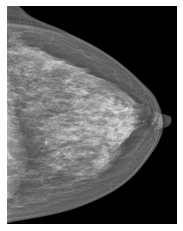

In [5]:
plt.imshow(im, cmap="Greys_r")
plt.axis("off")
plt.show()

In [5]:
# PREPARE IMAGE
# `img` is a PIL image of size 299x299
img = keras.preprocessing.image.load_img(img_path, target_size=img_size)
# `array` is a float32 Numpy array of shape (299, 299, 3)
img_array = keras.preprocessing.image.img_to_array(img)
# We add a dimension to transform our array into a "batch"
# of size (1, 299, 299, 3)
img_array = np.expand_dims(img_array, axis=0)
#img_array = loaded_image
img_array = batch
#-------------------------------------------------------------------------------------------------------------------

# Remove last layer's softmax
model.layers[-1].activation = None

#-------------------------------------------------------------------------------------------------------------------

# Generate class activation heatmap
#heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
grad_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
)

pred_index=None
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    if pred_index is None:
        pred_index = tf.argmax(preds[0])
    class_channel = preds[:, pred_index]

grads = tape.gradient(class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

In [9]:
#heatmap

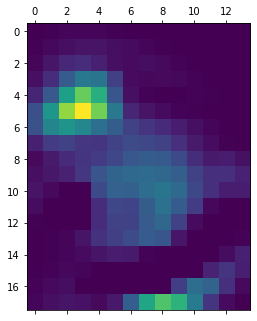

In [6]:
plt.matshow(heatmap)
plt.show()

In [8]:
heatmap1 = heatmap.numpy()


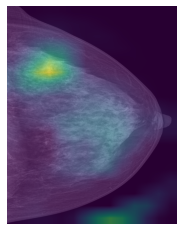

In [9]:
plt.figure()
a = cv2.resize(heatmap1, (896, 1152))
heatmap1 = a
plt.imshow(im, cmap="Greys_r")
plt.imshow(a, alpha=0.6)
plt.axis("off")
plt.show()